In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from sklearn. metrics import classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("comments_final2.csv", encoding="utf-8", index_col=0)

In [3]:
df.shape

(934543, 2)

In [4]:
df.head()

,processed_text,class
0,miếng dán hơi_dầy không_thẩm,neutral
1,miếng dán rất_tồi bóc bụi giải_quyết thỏa_đáng...,neutral
2,cường_lực trắng màu đen,negative
3,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...,negative
4,chất_lượng cường_lực chống trộm không_như quản...,negative


In [5]:
df['class'] = df['class'].apply(lambda x: 0 if x == 'negative' or x== 'neutral' else 1 )

In [6]:
df['class'].value_counts()

1    636052
0    298491
Name: class, dtype: int64

### Check NAN again

In [7]:
print('Data shape:', df.shape)
missing_val_num = df.isnull().sum()
missing_percent = (missing_val_num / df.shape[0]) * 100
missing_info = {'missing_values': missing_val_num,
                'missing_percent': round(missing_percent,3)}
missing_df = pd.DataFrame(missing_info)
missing_df

Data shape: (934543, 2)


,missing_values,missing_percent
processed_text,33669,3.603
class,0,0.000


In [8]:
# Drop all rows with NaN values
df.dropna(inplace=True)
print(df.shape)
print(df.isnull().sum())

(900874, 2)
processed_text    0
class             0
dtype: int64


### Duplicate Data

In [9]:
# Display duplicate rows
print('Duplicate data:', df.duplicated().sum())
df[df.duplicated()]

Duplicate data: 370328


,processed_text,class
76,hàng,0
132,hàng,0
188,hàng,0
240,nhầm,0
243,hỏng,0
...,...,...
934527,chất_lượng sản_phẩm kém,0
934528,hình_ảnh ví_dụ không_liên quan thái_độ làm_ăn ...,0
934533,chất_lượng sản_phẩm tạm,0
934534,chất_lượng sản_phẩm,0


In [10]:
# Drop all duplicate rows
df.drop_duplicates(inplace=True)
print('Duplicate data:', df.duplicated().sum())
print(df.shape)
# Reset index
df.reset_index(drop=True, inplace=True)

Duplicate data: 0
(530546, 2)


In [11]:
df['class'].value_counts()

1    313718
0    216828
Name: class, dtype: int64

### TF-IDF Vectorizer

In [12]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [13]:
# Fit the TfidfVectorizer object to the data
x = tfidf_vectorizer.fit(df['processed_text'].values.astype('U'))

In [14]:
# Transform the data
X = tfidf_vectorizer.transform(df['processed_text'].values.astype('U'))

In [15]:
### BUG: 
# This is probably because you are using an older scikit-learn version than the one this code was written for.
# get_feature_names_out is a method of the class sklearn.feature_extraction.text.TfidfVectorizer since scikit-learn 1.0. Previously, there was a similar method called get_feature_names.
# So you should update your scikit-learn package, or use the old method (not recommended).
# Create a new dataframe with the transformed data
df_new = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [16]:
df_new.head()

,bé,chuẩn,chất,chất vải,chất_liệu,chất_lượng,chất_lượng sản_phẩm,cũng_không,cẩn_thận,dày_dặn,...,đóng_gói,đường,đầu,đẹp,đẹp lắm,đồ,đổi,ảnh,ổn,ủng_hộ
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.510184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.789165,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.638137,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y = df['class']

In [18]:
print(X.shape, y.shape)

(530546, 60) (530546,)


### Resampling with SMOTE

In [20]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [21]:
smt = SMOTE()
X_smt, y_smt = smt.fit_resample(X,y)

### Cross Validation

In [24]:
# Choose 0.3, 0.2 as the test size
test_size_list = [.3, .2]
# Run 5 times for each test_size
for test_size in test_size_list:
  print('Test size: ', test_size)
  accuracy_train_list = []
  accuracy_test_list = []
  for i in range(5):
    print('Run: ', i)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # Create a LogisticReg (for faster training)
    clf = LogisticRegression()
    # Train the classifier
    clf.fit(X_train, y_train)
    # Make predictions
    y_pred = clf.predict(X_test)
    # Calculate the accuracy
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
  print('Test size: ', test_size, ' Train accuracy: ', sum(accuracy_train_list) / len(accuracy_train_list), ' Test accuracy: ',
      sum(accuracy_test_list) / len(accuracy_test_list))
  print('--------------------------------------------------')

Test size:  0.3
Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Test size:  0.3  Train accuracy:  0.7304489716787566  Test accuracy:  0.7308072177125481
--------------------------------------------------
Test size:  0.2
Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Test size:  0.2  Train accuracy:  0.730650086232082  Test accuracy:  0.7307529921779286
--------------------------------------------------


- test size 0.2 vẫn tốt hơn môt chút, nhưng không đáng kể

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Comparision

In [32]:
models = [
    ExtraTreesClassifier(n_estimators=50),
    ExtraTreesClassifier(n_estimators=100),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=7),
    XGBClassifier(),
    LogisticRegression(multi_class='multinomial')
    
]

In [38]:
def get_model_name(model):
  model_name = model.__class__.__name__
  if model_name == 'ExtraTreesClassifier':
    model_name = model_name + '_' + str(model.n_estimators)
  elif model_name == 'KNeighborsClassifier':
    model_name = model_name + '_' + str(model.n_neighbors)
    
  return model_name

In [39]:
# Number of folds for cross validation
num_folds = 5
# A dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy Mean', 'Accuracy 3 * STD', 'Time'])
# Integrate through models
for model in models:
  # Get model name
  model_name = get_model_name(model)  
  print('Model: ', model_name, 'running...')
  # Get the current time
  start_time = datetime.now()  
  # Perform cross validation
  cv_results = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='accuracy', n_jobs=-1)  
  # Get the training time
  train_time = datetime.now() - start_time  
  # Get the mean and std of the results
  mean_cv_results = cv_results.mean()
  std_cv_results = cv_results.std()  
  # Store the results
  results = results.append({'Model': model_name,
                            'Accuracy Mean': mean_cv_results,
                            'Accuracy 3 * STD': 3 * std_cv_results,
                            'Time': train_time
                            }, ignore_index=True)

Model:  ExtraTreesClassifier_50 running...
Model:  ExtraTreesClassifier_100 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_3 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_5 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_7 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  XGBClassifier running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,
/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  LogisticRegression running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_9407/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


### Metric result

In [41]:
# Sort the dataframe by Accuracy Mean in descending order
results = results.sort_values(by='Accuracy Mean', ascending=False).reset_index(drop=True)
results

,Model,Accuracy Mean,Accuracy 3 * STD,Time
0,XGBClassifier,0.737970,0.007833,0 days 00:00:43.688862
1,LogisticRegression,0.731168,0.004531,0 days 00:00:02.618764
2,ExtraTreesClassifier_100,0.725132,0.005313,0 days 00:16:01.077556
3,ExtraTreesClassifier_50,0.724722,0.004964,0 days 00:08:01.703597
4,KNeighborsClassifier_7,0.713874,0.004324,0 days 00:13:13.529574
5,KNeighborsClassifier_5,0.707035,0.005008,0 days 00:13:12.964282
6,KNeighborsClassifier_3,0.697467,0.004447,0 days 00:13:10.246078


Text(0.5, 1.0, 'Model Comparison')

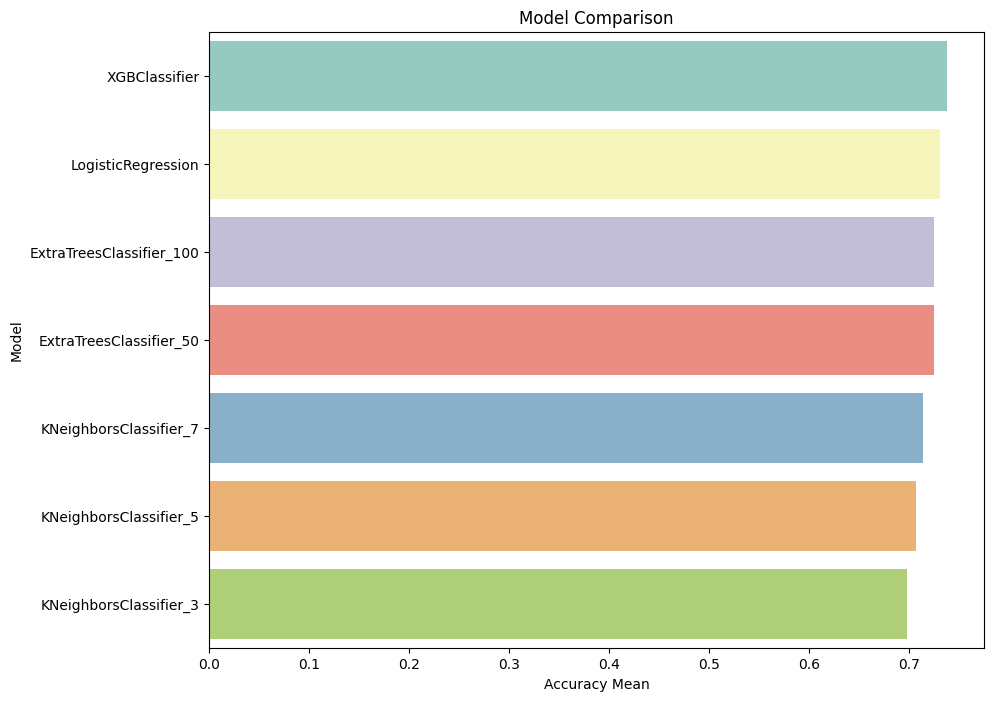

In [42]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy Mean', y='Model', data=results, palette='Set3')
plt.title('Model Comparison')

###
- Như vậy, ta có thể sơ bộ thấy mô hình logistic Reg cho kết quả tốt hơn các mô hình còn lại

### Classification Report

### 
- Đối với bài toán phân loại này, chúng ta cần quan tâm tới high Recall rating not_like.
- với high Recall cao, thì các True rating not-like phải cao, còn các False-not_like dự báo có thể cao hoặc thấp. 

### 
- Như vậy ta chon Logistic Regression cho việc tinh chỉnh mô hình tối ưu

### Logistic Regression

#### Hyperparameter tuning

In [43]:
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a list of parameters of Logistic Regression for the GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
#param_grid = {
    #'n_estimators': [100,300, 500, 1000],
    #'learning_rate':[0.001,0.01,0.1, 1]
#}
# Create a list of models to test
clf_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy', error_score=0)
search_clf = clf_grid.fit(X_train, y_train)
best_clf = search_clf.best_estimator_

##Score
#cross_clf = cross_val_score(best_clf, X_test, y_test, scoring='accuracy', cv=5, n_jobs=-1)

In [44]:
print('Best params:', search_clf.best_params_)

Best params: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


### Best Params

In [45]:
## Create the best model
best_model = LogisticRegression(C= 100,penalty='l2',solver= 'newton-cg')
# Fit the best model to the training data
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

### Metrics to Report

In [46]:
# Get the accuracy score for the best model
accuracy_train = round(best_model.score(X_train, y_train) * 100, 3)
accuracy_test = round(best_model.score(X_test, y_test) * 100, 3)
print('Accuracy score for the best model on the training data: ', accuracy_train)
print('Accuracy score for the best model on the test data: ', accuracy_test)

Accuracy score for the best model on the training data:  73.102
Accuracy score for the best model on the test data:  72.944


              precision    recall  f1-score   support

           0       0.66      0.69      0.67     43312
           1       0.78      0.76      0.77     62798

    accuracy                           0.73    106110
   macro avg       0.72      0.72      0.72    106110
weighted avg       0.73      0.73      0.73    106110



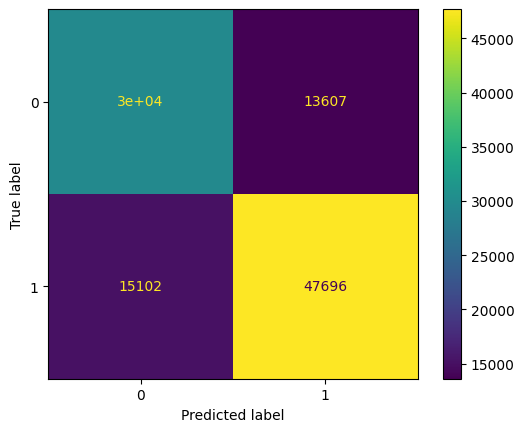

In [47]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

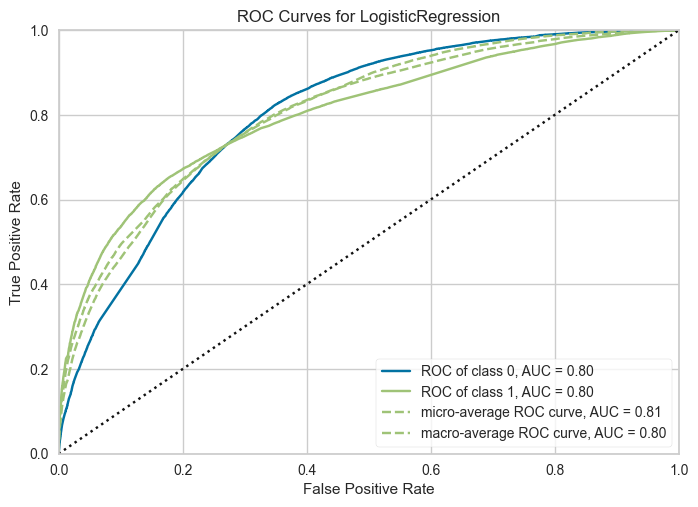

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, roc_auc
visualizer = ROCAUC(best_model, classes=y.unique())

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()